Install keras

In [1]:
!pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download data and uncompress

In [2]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2023-06-03 16:47:48--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2023-06-03 16:47:48--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1daef2430c4d22be0860cd4550.dl.dropboxusercontent.com/cd/0/inline/B9QQMJKJP4RDHaOMrT0_LkDBI3HdwIE4EqVZzyhOym1ECO2ec8eAIyGvaaPQoxFJYvB8Wnyc63vly1P7du-gCXNO389zG2H1F32xlBAd09K5Lqa9ySJPPVO7O2RXUU6yd8-WTTdB0LcEyOHVnKYZtgGr19BdAlLFIviaDDJQuRdF1Q/file# [following]
--2023-06-03 16:47:48--  https://uc1daef2430c4d22be0860cd4550.dl.dropboxusercontent.com/cd/0/inline/B9QQMJKJP4RDHaOMrT0_LkDBI3HdwIE4EqVZzyhOym1ECO2ec8eAIyGvaaPQoxFJYvB8Wnyc63vly1P7du-g

Import packages 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Load and prepare data

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


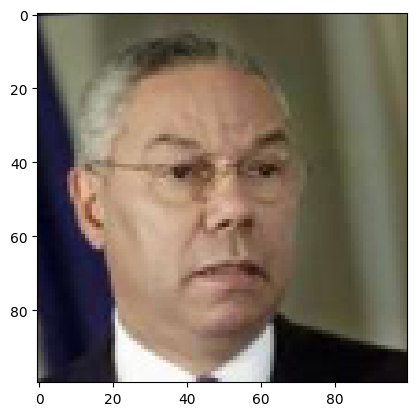

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [4]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Create model, data augmentation etc... 

In [5]:
## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = 0.2)

In [6]:
batch_size = 64
epochs = 100

In [17]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

In [19]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,32)
model.add(Dropout(0.1))
model=CBGN(model,64)
model=CBGN(model,64)

model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_28 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 gaussian_noise_28 (Gaussian  (None, 100, 100, 32)     0         
 Noise)                                                          
                                                                 
 activation_28 (Activation)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

In [20]:
# Early Stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    mode=min
)
#Checkpoint
mc = ModelCheckpoint(
    'best_m.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience = 15)

In [22]:
def plot_evolution(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.77492, saving model to best_m.h5
165/165 - 43s - loss: 0.5345 - accuracy: 0.7725 - val_loss: 0.5267 - val_accuracy: 0.7749 - lr: 0.0010 - 43s/epoch - 260ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.77492 to 0.78134, saving model to best_m.h5
165/165 - 31s - loss: 0.4309 - accuracy: 0.7999 - val_loss: 0.4363 - val_accuracy: 0.7813 - lr: 0.0010 - 31s/epoch - 185ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.78134 to 0.84101, saving model to best_m.h5
165/165 - 29s - loss: 0.4136 - accuracy: 0.8135 - val_loss: 0.3716 - val_accuracy: 0.8410 - lr: 0.0010 - 29s/epoch - 177ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.84101 to 0.86405, saving model to best_m.h5
165/165 - 29s - loss: 0.3771 - accuracy: 0.8324 - val_loss: 0.3060 - val_accuracy: 0.8640 - lr: 0.0010 - 29s/epoch - 178ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.86405
165/165 - 30s - loss: 0.3533 - accuracy: 0.8464

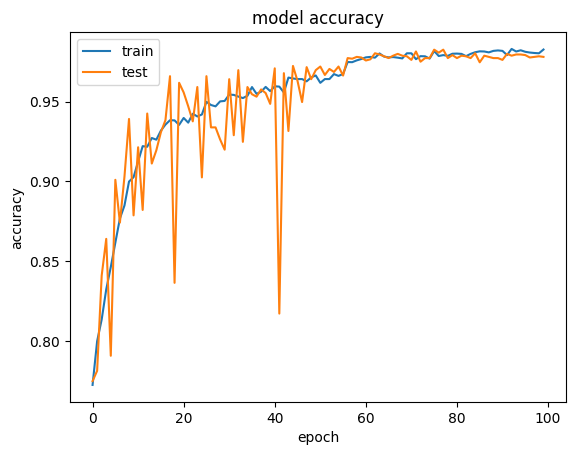

In [24]:
## TRAINING with DA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[es,mc, reduce_lr],
                            verbose=2)
plot_evolution(history)

In [25]:
## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

83/83 [==============================] - 1s 9ms/step - loss: 0.0590 - accuracy: 0.9781
Test loss: 0.05897921696305275
Test accuracy: 0.9780966639518738


In [26]:
from tensorflow.keras.models import load_model

In [27]:
# load the saved model
saved_model = load_model('best_m.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.992, Test: 0.983
